Import packages

In [26]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

Set global variables

In [27]:
OUTPUT_PATH = '../data/postprocessing/240226_benchmark/'

CO2_PRICE = 95.98
HEAT_PRICE = 0
H2_PRICE = 81.01

Read output data

In [28]:
output_df = pd.read_csv(OUTPUT_PATH + 'ngas_h2_50_50_output.csv', index_col=0)

Prepare class for Assets

In [33]:
class Assets:
    """Class for evaluating asset output data."""

    def __init__(self, input_data: pd.DataFrame) -> None:
        self.ids = []
        self.input_data = input_data
        self.asset_data = {}
        self.postprocess_data = {}
        self.objective_value = None

        self.get_asset_ids()
        self.get_asset_data()
        self.calc_postprocess_data()
        self.get_objective_value_from_log()


    def get_asset_ids(self):
        """Get all unique asset names from the input data."""
        ids_set = set()

        for column_name in self.input_data.columns:
            if not '.' in column_name:
                continue
            key = re.sub('\..*$', '', column_name)      # Replace every character after a '.'.
            key = key.replace('_expanded', '')          # Replace additional characters.
            ids_set.add(key)                            # Remove duplicate keys.
        
        for id in ids_set:
            self.ids.append(id)
        
        self.ids.sort()

        if not self.ids:
            raise ValueError("""Found no asset ids in input data.""")


    def get_asset_data(self):
        """Get the specific asset data from the input data."""

        for id in self.ids:
            asset_df = pd.DataFrame()

            for column_name in self.input_data.columns:
                if id in column_name:
                    key_name = re.sub('^.*\.', '', column_name)
                    asset_df[key_name] = self.input_data[column_name]
            
            self.asset_data[id] = asset_df


    def calc_postprocess_data(self):
        """Calculates the sum of all columns in the asset data."""

        for key in self.asset_data:
            asset_dict = {}
            for column in self.asset_data[key].columns:
                column_sum = self.asset_data[key][column].sum()
                asset_dict[column] = column_sum
                self.postprocess_data[key] = asset_dict
    
    
    def get_objective_value_from_log(self):
        """Gets the objective value from the solver log file."""

        with open(OUTPUT_PATH + 'ngas_h2_50_50_solver.log', 'r') as log_file:
            for line in log_file:
                if 'Best objective' in line:
                    line = line.replace('Best objective ', '')
                    line = re.sub(',.*$', '', line)
                    self.objective_value = round(float(line), 1)
                    

    def check_objective_value(self):
        """Calculates the objective value from the output data and checks if it 
        is identical to the solver results."""

        result = sum(
            self.asset_data['ngas_grid']['ngas_balance'] 
            * self.input_data['gas_price'] 
            + self.asset_data['chp_1']['co2'] 
            * CO2_PRICE 
            + self.asset_data['chp_2']['co2'] 
            * CO2_PRICE 
            + self.asset_data['electrical_grid']['power_balance'] 
            * self.input_data['power_price'] 
            + self.asset_data['hydrogen_grid']['hydrogen_balance'] 
            * H2_PRICE 
            - self.asset_data['heat_grid']['heat_feedin'] 
            * HEAT_PRICE
            )

        result = round(result, 1)
        
        if result == self.objective_value:
            print('\nObjective value and calculated value are the same.')
            print(f'{self.objective_value} == {result}')
        else:
            print('\nObjective value and calculated value are not identical!')
            print(f'{self.objective_value} =/= {result}')


Calculate overview data for assets

In [34]:
assets = Assets(output_df)

df = pd.DataFrame(assets.postprocess_data)
print(df)

assets.check_objective_value()

                           arc01          arc02       arc03   arc04   arc05        arc06        arc07        arc08        arc09        arc10  ...  electrolyzer_3  electrolyzer_4  electrolyzer_5  electrolyzer_6    heat_grid  heat_storage      heatpump  hydrogen_grid     ngas_grid          pv
power              182598.179984  180577.560669  1202.36788  4552.0  4552.0  8375.640756  8361.752422  8389.334976  8408.966678  8351.390438  ...    8.389335e+03    8.408967e+03    8.351390e+03    8.373058e+03          NaN           NaN  11367.486977            NaN           NaN  1202.36788
hydrogen                     NaN            NaN         NaN     NaN     NaN          NaN          NaN          NaN          NaN          NaN  ...    5.272083e+03    5.284420e+03    5.248237e+03    5.261854e+03          NaN           NaN           NaN            NaN           NaN         NaN
natural_gas                  NaN            NaN         NaN     NaN     NaN          NaN          NaN          NaN          

# Functions for plotting

### Heat Storage - plot_heat_storage()

In [76]:
FONTSIZE = 11
LABELSIZE = 14

plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

def plot_heat_storage(xlim=None):
    """Function for plotting the heat storage behaviour."""
    
    charge = assets.asset_data['heat_storage']['heat_charging']
    discharge = assets.asset_data['heat_storage']['heat_discharging'] * - 1
    content = assets.asset_data['heat_storage']['heat_content']

    x = range(1, len(charge) + 1)

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13, 7.5), dpi=120)


    # Plotting areas inbetween curves for charging, discharging and storage 
    # content
    # HEAT STORAGE
    axs[0].fill_between(x,
                        content,
                        step='pre',
                        alpha=0.5,
                        label='content',
                        color='gold')
    axs[1].fill_between(x,
                        discharge,
                        step='pre',
                        alpha=0.5,
                        label='discharge')
    axs[1].fill_between(x,
                        charge,
                        step='pre',
                        alpha=0.5,
                        label='charge')


    # Plotting discharge and charge power as well as storage content
    # HEAT STORAGE
    axs[1].plot(x,
                discharge,
                drawstyle='steps')
    axs[1].plot(x,
                charge,
                drawstyle='steps')
    axs[0].plot(x,
                content,
                drawstyle='steps',
                color='gold')


    # Preparing differnt axis settings
    # HEAT STORAGE
    axs[0].set_xlabel('time [h]', fontsize=LABELSIZE)
    axs[0].set_ylabel('heat [MWh]', fontsize=LABELSIZE)
    axs[1].set_xlabel('time [h]', fontsize=LABELSIZE)
    axs[1].set_ylabel('thermal power [MW]', fontsize=LABELSIZE)

    axs[0].grid()
    axs[1].grid()


    # Optional x-axis settings
    if xlim:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)


    # Declaring joint legend labeling
    handle_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lists, []) for lists in zip(*handle_labels)]

    fig.legend(handles,
               labels,
               ncol=3,
               bbox_to_anchor=(0.99, 1.04),
               fontsize=FONTSIZE)
    

    # Thight layout for tidy graphics
    fig.tight_layout()

### Battery Storage - plot_battery_storage()

In [ ]:
def plot_battery_storage(xlim=None):
    """Function for plotting the battery storage behaviour."""
    
    charge = assets.asset_data['battery_storage']['power_charging']
    discharge = assets.asset_data['battery_storage']['power_discharging'] * - 1
    content = assets.asset_data['battery_storage']['power_content']

    x = range(1, len(charge) + 1)

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13, 7.5), dpi=120)


    # Plotting areas inbetween curves for charging, discharging and storage 
    # content
    # BATTERY
    axs[0].fill_between(x,
                        content,
                        step='pre',
                        alpha=0.5,
                        label='content',
                        color='gold')
    axs[1].fill_between(x,
                        discharge,
                        step='pre',
                        alpha=0.5,
                        label='discharge')
    axs[1].fill_between(x,
                        charge,
                        step='pre',
                        alpha=0.5,
                        label='charge')


    # Plotting discharge and charge power as well as storage content
    # BATTERY
    axs[0].plot(x,
                content,
                drawstyle='steps',
                color='gold')
    axs[1].plot(x,
                discharge,
                drawstyle='steps')
    axs[1].plot(x,
                charge,
                drawstyle='steps')


    # Preparing differnt axis settings
    # BATTERY
    axs[0].set_xlabel('time [h]', fontsize=LABELSIZE)
    axs[0].set_ylabel('electrical energy [MWh]', fontsize=LABELSIZE)
    axs[1].set_xlabel('time [h]', fontsize=LABELSIZE)
    axs[1].set_ylabel('power [MW]', fontsize=LABELSIZE)

    axs[0].grid()
    axs[1].grid()


    # Optional x-axis settings
    if xlim:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)


    # Declaring joint legend labeling    
    handle_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lists, []) for lists in zip(*handle_labels)]

    fig.legend(handles,
               labels,
               ncol=3,
               bbox_to_anchor=(0.99, 1.04),
               fontsize=FONTSIZE)


    # Tight layout for tidy graphics
    fig.tight_layout()

### Energy balances - plot_energy_balance()

In [ ]:
def plot_energy_balance(xlim=None):
    """Function for plotting energy balances."""

    # Preparing heat data
    # ENERGY BALANCES
    chp_heat = (
        assets.asset_data['chp_1']['heat']
        + assets.asset_data['chp_2']['heat'])
    
    demand_heat = (
        assets.asset_data['heat_grid']['heat_feedin']
        - assets.asset_data['heat_grid']['heat_supply'])
    
    hp_heat = assets.asset_data['heatpump']['heat']
    out_heat = assets.asset_data['heat_storage']['heat_discharging']
    in_heat = -assets.asset_data['heat_storage']['heat_charging']

    # Preparing electrical power data
    # ENERGY BALANCES
    chp_power = (
        assets.asset_data['chp_1']['power']
        + assets.asset_data['chp_2']['power'])
    
    electrolyzer_power = (
        -assets.asset_data['electrolyzer_1']['power']
        - assets.asset_data['electrolyzer_2']['power']
        - assets.asset_data['electrolyzer_3']['power']
        - assets.asset_data['electrolyzer_4']['power']
        - assets.asset_data['electrolyzer_5']['power']
        - assets.asset_data['electrolyzer_6']['power'])
    
    hp_power = -assets.asset_data['heatpump']['power']
    out_power = assets.asset_data['battery_storage']['power_discharging']
    in_power = -assets.asset_data['battery_storage']['power_charging']
    pv_power = assets.asset_data['pv']['power']
    balance_power = -assets.asset_data['electrical_grid']['power_balance']
    
    # Preparing hydrogen data
    # ENERGY BALANCES
    chp_hydrogen = (
        -assets.asset_data['chp_1']['hydrogen']
        - assets.asset_data['chp_2']['hydrogen'])
    
    electrolyzer_hydrogen = (
        assets.asset_data['electrolyzer_1']['hydrogen']
        + assets.asset_data['electrolyzer_2']['hydrogen']
        + assets.asset_data['electrolyzer_3']['hydrogen']
        + assets.asset_data['electrolyzer_4']['hydrogen']
        + assets.asset_data['electrolyzer_5']['hydrogen']
        + assets.asset_data['electrolyzer_6']['hydrogen'])
    
    balance_hydrogen = -assets.asset_data['hydrogen_grid']['hydrogen_balance']
    
    x = np.arange(len(chp_heat)) + 1
    
    fig, axs = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(13, 7.5))


    # Plotting areas inbetween curves for heat assets
    # ENERGY BALANCES
    axs[0].fill_between(x, 
                        chp_heat,
                        step='pre',
                        color='C1',
                        alpha=0.5,
                        label='chp')
    axs[0].fill_between(x,
                        chp_heat, 
                        chp_heat + hp_heat, 
                        step='pre', 
                        color='C3', 
                        alpha=0.5, 
                        label='hp')
    axs[0].fill_between(x,
                        chp_heat + hp_heat,
                        chp_heat + hp_heat + out_heat,
                        step='pre',
                        color='C4',
                        alpha=0.5,
                        label='discharge')
    axs[0].fill_between(x, 
                        in_heat,
                        step='pre',
                        color='C2',
                        alpha=0.5,
                        label='charge')
    
    # Plotting heat demand
    # ENERGY BALANCES
    axs[0].plot(demand_heat,
                drawstyle='steps',
                color='dimgrey',
                label='demand')
    

    # Plotting areas inbetween curves for electrical power assets
    # ENERGY BALANCES
    axs[1].fill_between(x, 
                        chp_power, 
                        step='pre',
                        color='C1', 
                        alpha=0.5)
    axs[1].fill_between(x,
                        chp_power,
                        chp_power + pv_power,
                        step='pre',
                        color='C8',
                        alpha=0.5,
                        label='pv')
    axs[1].fill_between(x,
                        electrolyzer_power,
                        step='pre',
                        color='C0',
                        alpha=0.5,
                        label='electrolyzer')
    axs[1].fill_between(x,
                        electrolyzer_power, 
                        electrolyzer_power + hp_power, 
                        step='pre',
                        color='C3', 
                        alpha=0.5)
    axs[1].fill_between(x, 
                        chp_power + pv_power, 
                        chp_power + pv_power + out_power, 
                        step='pre', 
                        color='C4',
                        alpha=0.5)
    axs[1].fill_between(x, 
                        electrolyzer_power + hp_power, 
                        electrolyzer_power + hp_power + in_power, 
                        step='pre', 
                        color='C2',
                        alpha=0.5)
    

    # Plotting power balance
    # ENERGY BALANCES
    axs[1].plot(balance_power, 
                drawstyle='steps', 
                color='dimgrey', 
                label='balance')
    

    # Plotting areas inbetween curves for hydrogen assets
    # ENERGY BALANCES
    axs[2].fill_between(x, 
                        chp_hydrogen, 
                        step='pre', 
                        color='C1',
                        alpha=0.5)
    axs[2].fill_between(x, 
                        electrolyzer_hydrogen, 
                        step='pre', 
                        color='C0', 
                        alpha=0.5)
    

    # Plotting hydrogen balance
    # ENERGY BALANCES
    axs[2].plot(balance_hydrogen, 
                drawstyle='steps', 
                color='dimgrey')
    

    # Preparing differnt axis settings
    # ENERGY BALANCES
    axs[0].set_ylabel('thermal power [MW]', fontsize=LABELSIZE)
    axs[0].set_xlabel('time [h]', fontsize=LABELSIZE)
    axs[0].grid()

    axs[1].set_ylabel('electrical power [MW]', fontsize=LABELSIZE)
    axs[1].set_xlabel('time [h]', fontsize=LABELSIZE)
    axs[1].grid()
    
    axs[2].set_ylabel('hydrogen [MWh/h]', fontsize=LABELSIZE)
    axs[2].set_xlabel('time [h]', fontsize=LABELSIZE)
    axs[2].grid()


    # Optional x-axis settings
    if xlim:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)
        axs[2].set_xlim(xlim)
    

    # Declaring joint legend labeling  
    fig.legend(ncol=8,
               bbox_to_anchor=(0.99, 1.04),
               fontsize=FONTSIZE)
    

    # Tight layout for tidy graphics
    fig.tight_layout()

### Costs - plot_costs()

In [ ]:
def plot_costs(xlim=None):
    "Function for plotting specific and cumulative costs."

    # Preparing energy balance data
    # COSTS
    power_data = assets.asset_data['electrical_grid']['power_balance']
    hydrogen_data = assets.asset_data['hydrogen_grid']['hydrogen_balance']

    # Preparing cost data
    # COSTS
    ngas_costs = (
        assets.asset_data['ngas_grid']['ngas_balance'] 
        * assets.input_data['gas_price']
        / 1000)
    co2_costs = ((
        assets.asset_data['chp_1']['co2'] * CO2_PRICE 
        + assets.asset_data['chp_2']['co2'] * CO2_PRICE)
        / 1000)
    power_costs = (
        power_data.where(power_data >= 0, 0) 
        * assets.input_data['power_price']
        / 1000)
    power_revenue = (
        power_data.where(power_data <= 0, 0) 
        * assets.input_data['power_price']
        / 1000)
    hydrogen_costs = (
        hydrogen_data.where(hydrogen_data >= 0, 0) 
        * H2_PRICE
        / 1000)
    hydrogen_revenue = (
        hydrogen_data.where(hydrogen_data <= 0, 0) 
        * H2_PRICE 
        / 1000)

    # Preparing overall cost data
    # COSTS
    costs = ((
        assets.asset_data['ngas_grid']['ngas_balance'] 
        * assets.input_data['gas_price'] 
        + assets.asset_data['chp_1']['co2'] 
        * CO2_PRICE 
        + assets.asset_data['chp_2']['co2'] 
        * CO2_PRICE 
        + assets.asset_data['electrical_grid']['power_balance'] 
        * assets.input_data['power_price'] 
        + assets.asset_data['hydrogen_grid']['hydrogen_balance'] 
        * H2_PRICE)
        / 1000)

    x = range(1, len(ngas_costs) + 1)

    fig, ax = plt.subplots(figsize=(13, 7.5), dpi=120)

        
    # Plotting areas inbetween curves for cost positions
    # COSTS
    ax.fill_between(x,
                    ngas_costs,
                    step='pre',
                    alpha=0.5,
                    label='ngas')
    ax.fill_between(x,
                    ngas_costs,
                    ngas_costs+ co2_costs,
                    step='pre',
                    alpha=0.5,
                    label='co2')
    ax.fill_between(x,
                    ngas_costs + co2_costs,
                    ngas_costs + co2_costs + power_costs,
                    step='pre',
                    alpha=0.5,
                    label='power_costs')
    ax.fill_between(x,
                    ngas_costs + co2_costs + power_costs,
                    ngas_costs + co2_costs + power_costs + hydrogen_costs,
                    step='pre',
                    alpha=0.5,
                    label='hydrogen_costs')
    ax.fill_between(x,
                    power_revenue,
                    step='pre',
                    alpha=0.5,
                    label='power_revenue')
    ax.fill_between(x,
                    power_revenue,
                    power_revenue + hydrogen_revenue,
                    step='pre',
                    alpha=0.5,
                    label='hydrogen_revenue')
    

    # Plotting cost balance
    # COSTS
    ax.plot(x, 
            costs, 
            drawstyle='steps', 
            label='balance')
    

    # Preparing differnt axis settings
    # COSTS
    ax.set_xlabel('t [h]', fontsize=LABELSIZE)
    ax.set_ylabel('costs [T EUR]', fontsize=LABELSIZE)

    ax.grid()


    # Optional x-axis settings
    if xlim:
        ax.set_xlim(xlim)
    
    
    # Declaring joint legend labeling
    ax.legend(ncol=7,
              bbox_to_anchor=(0.99, 1.07),
              fontsize=FONTSIZE)
    

    # Tight layout for tidy labeling
    fig.tight_layout()



    ### CUMULATIV COSTS PLOT

    fig, ax = plt.subplots(figsize=(13, 7.5), dpi=120)

    # Plotting areas inbetween curves for cost positions
    # CUMULATIV COSTS
    ax.fill_between(x, 
                    ngas_costs.cumsum(), 
                    step='pre', 
                    alpha=0.5,
                    label='gas_costs')
    ax.fill_between(x, 
                    ngas_costs.cumsum(), 
                    ngas_costs.cumsum() 
                    + co2_costs.cumsum(), 
                    step='pre', 
                    alpha=0.5,
                    label='co2_costs')
    ax.fill_between(x, 
                    ngas_costs.cumsum() 
                    + co2_costs.cumsum(), 
                    ngas_costs.cumsum() 
                    + co2_costs.cumsum() 
                    + power_costs.cumsum(),
                    step='pre', 
                    alpha=0.5,
                    label='power_costs')
    ax.fill_between(x,  
                    ngas_costs.cumsum() 
                    + co2_costs.cumsum() 
                    + power_costs.cumsum(),
                    ngas_costs.cumsum() 
                    + co2_costs.cumsum() 
                    + power_costs.cumsum() 
                    + hydrogen_costs.cumsum(),
                    step='pre', 
                    alpha=0.5,
                    label='hydrogen_costs')
    ax.fill_between(x,  
                    power_revenue.cumsum(),
                    step='pre', 
                    alpha=0.5,
                    label='power_revenue')
    ax.fill_between(x,  
                    power_revenue.cumsum(),
                    power_revenue.cumsum() + hydrogen_revenue.cumsum(),
                    step='pre', 
                    alpha=0.5,
                    label='hydrogen_revenue')
    

    # Plotting cumulativ cost balance
    # CUMULATIV COSTS
    ax.plot(x, costs.cumsum(), drawstyle='steps', label='balance')


    # Preparing differnt axis settings
    # COSTS
    ax.set_xlabel('t [h]', fontsize=LABELSIZE)
    ax.set_ylabel('costs [T EUR]', fontsize=LABELSIZE)

    ax.grid()


    # Optional x-axis settings
    if xlim:
        ax.set_xlim(xlim)


    # Declaring joint legend labeling
    ax.legend(ncol=7, 
              bbox_to_anchor=(0.99, 1.07),
              fontsize=FONTSIZE)
    

    # Tight layout for tidy graphics
    fig.tight_layout()

### Plotting

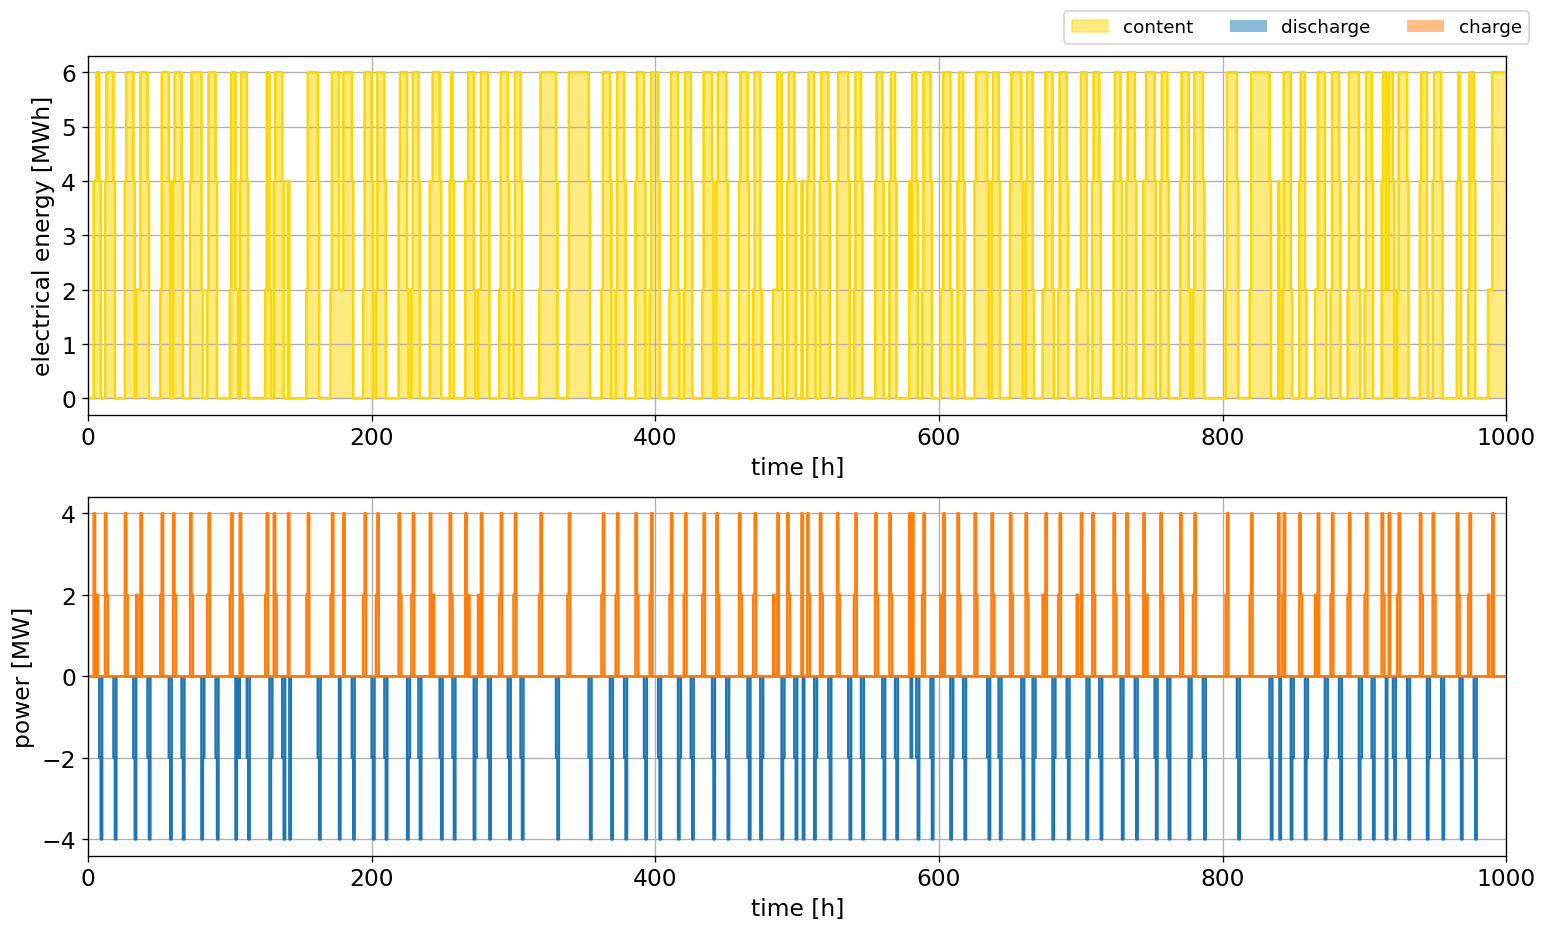

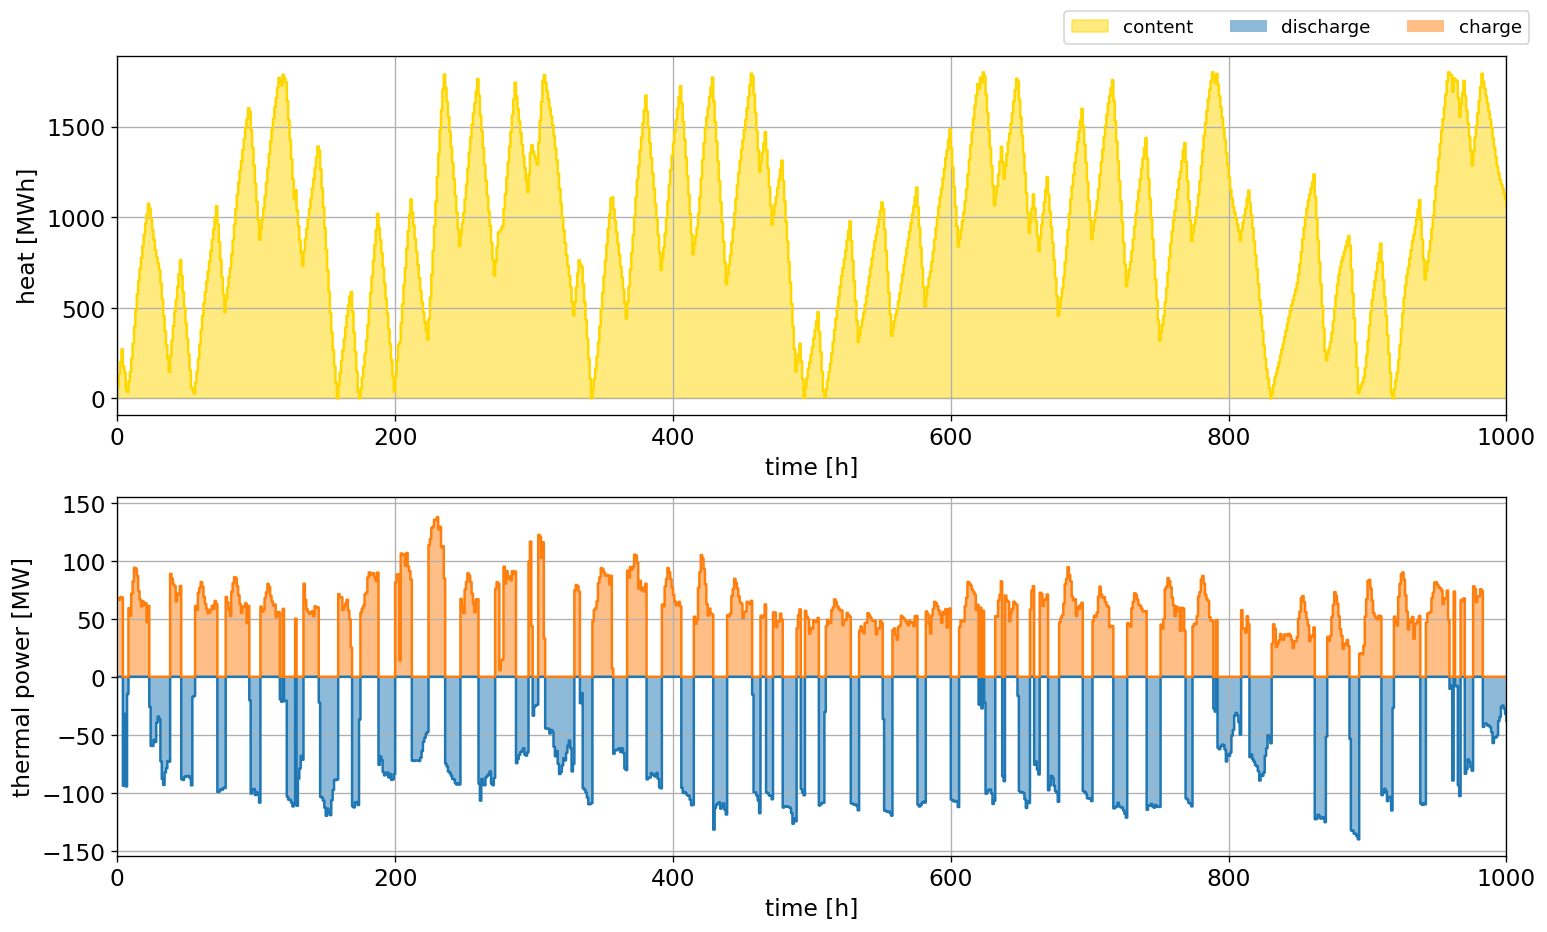

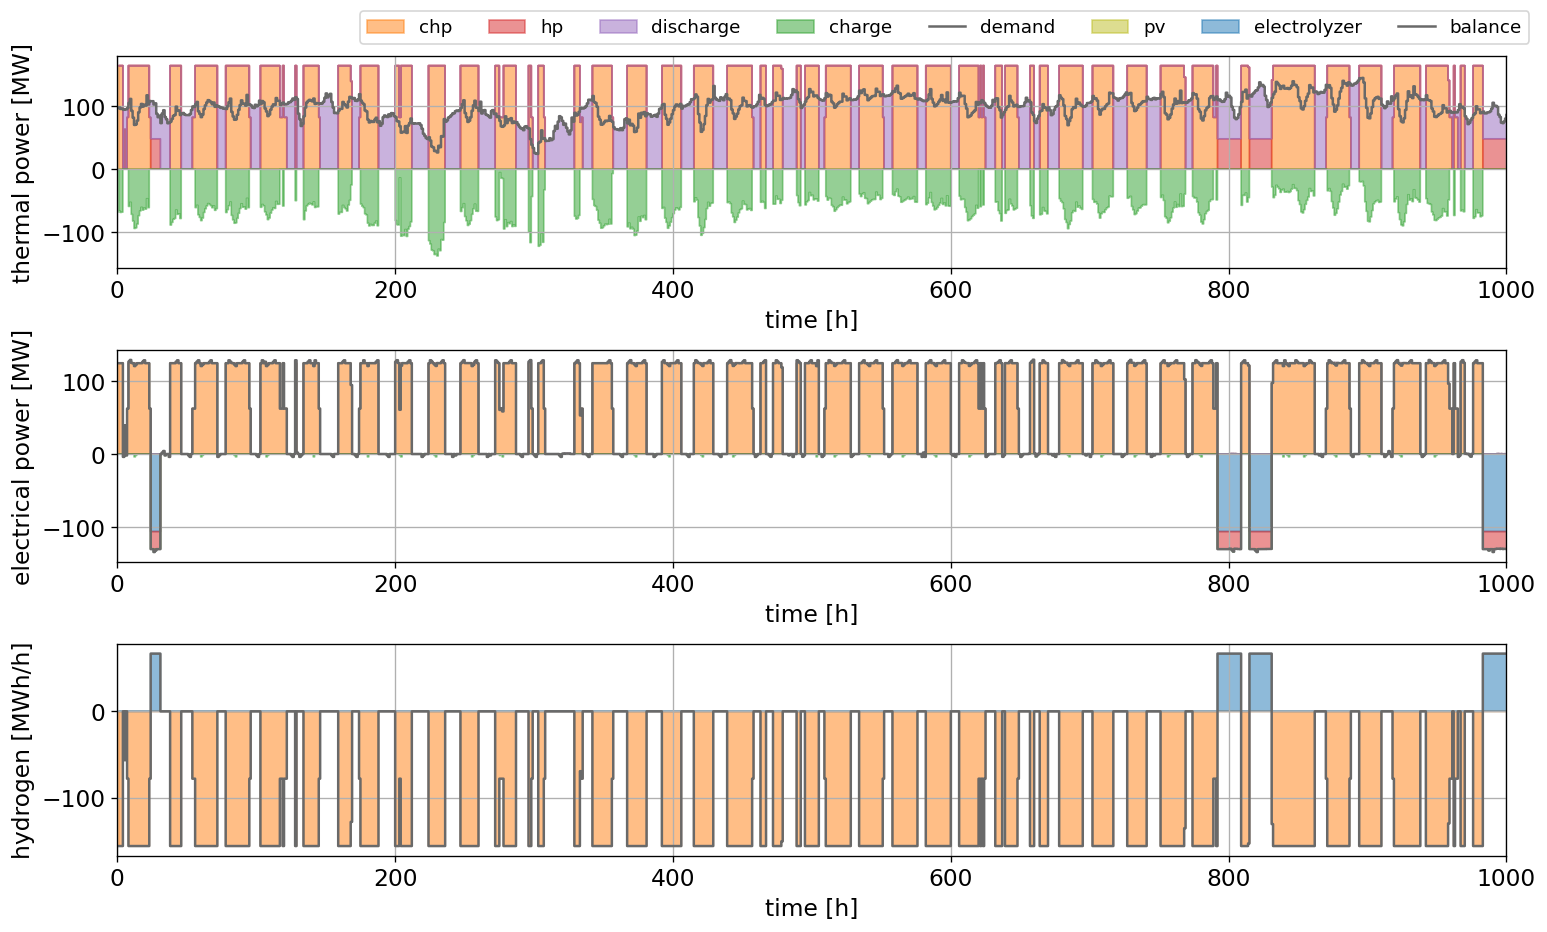

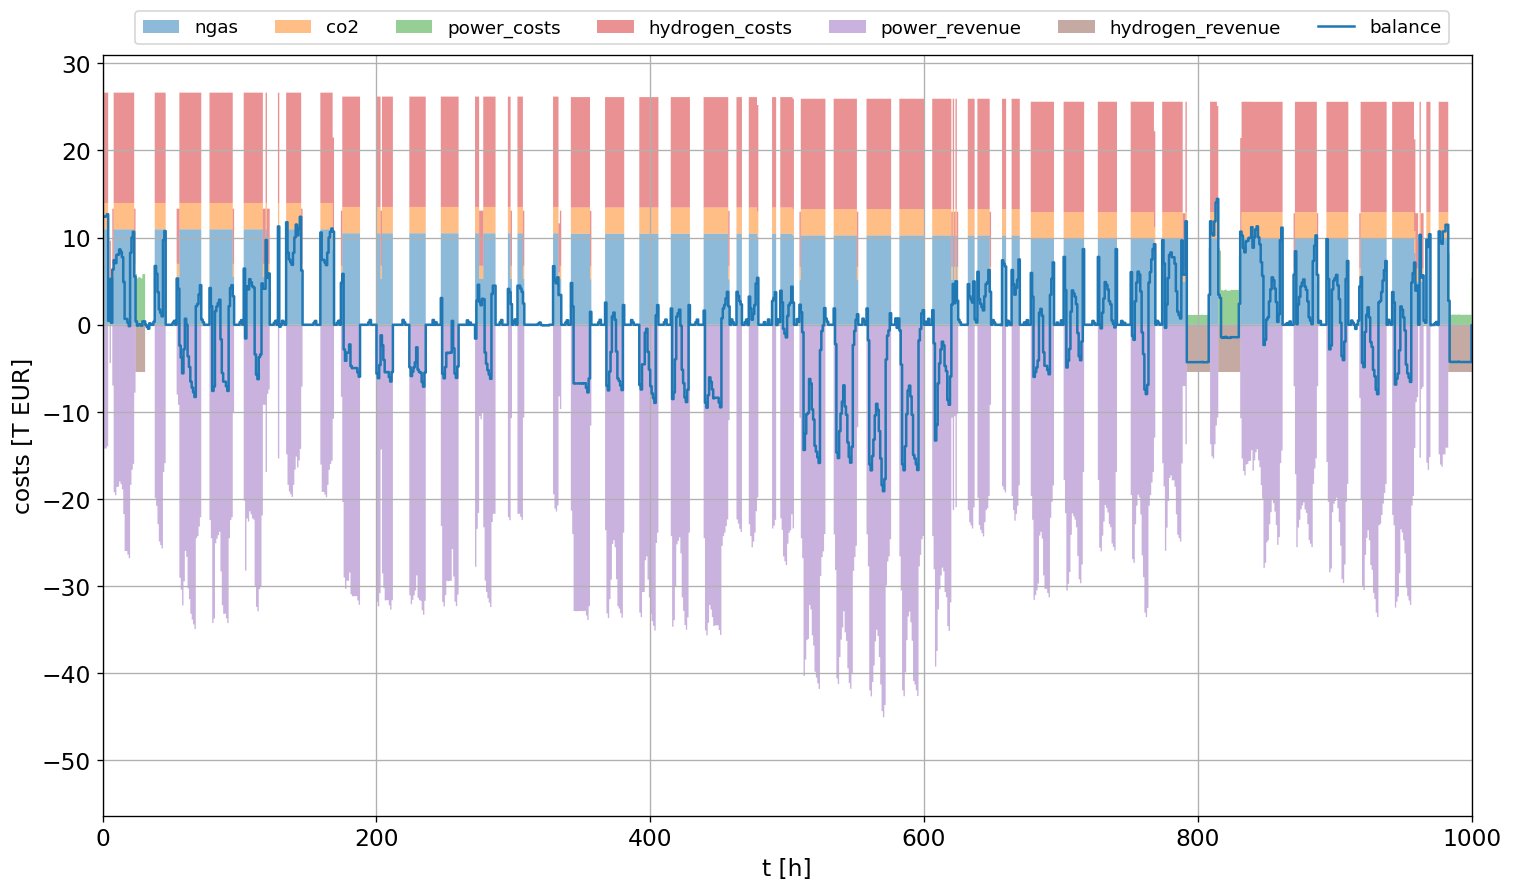

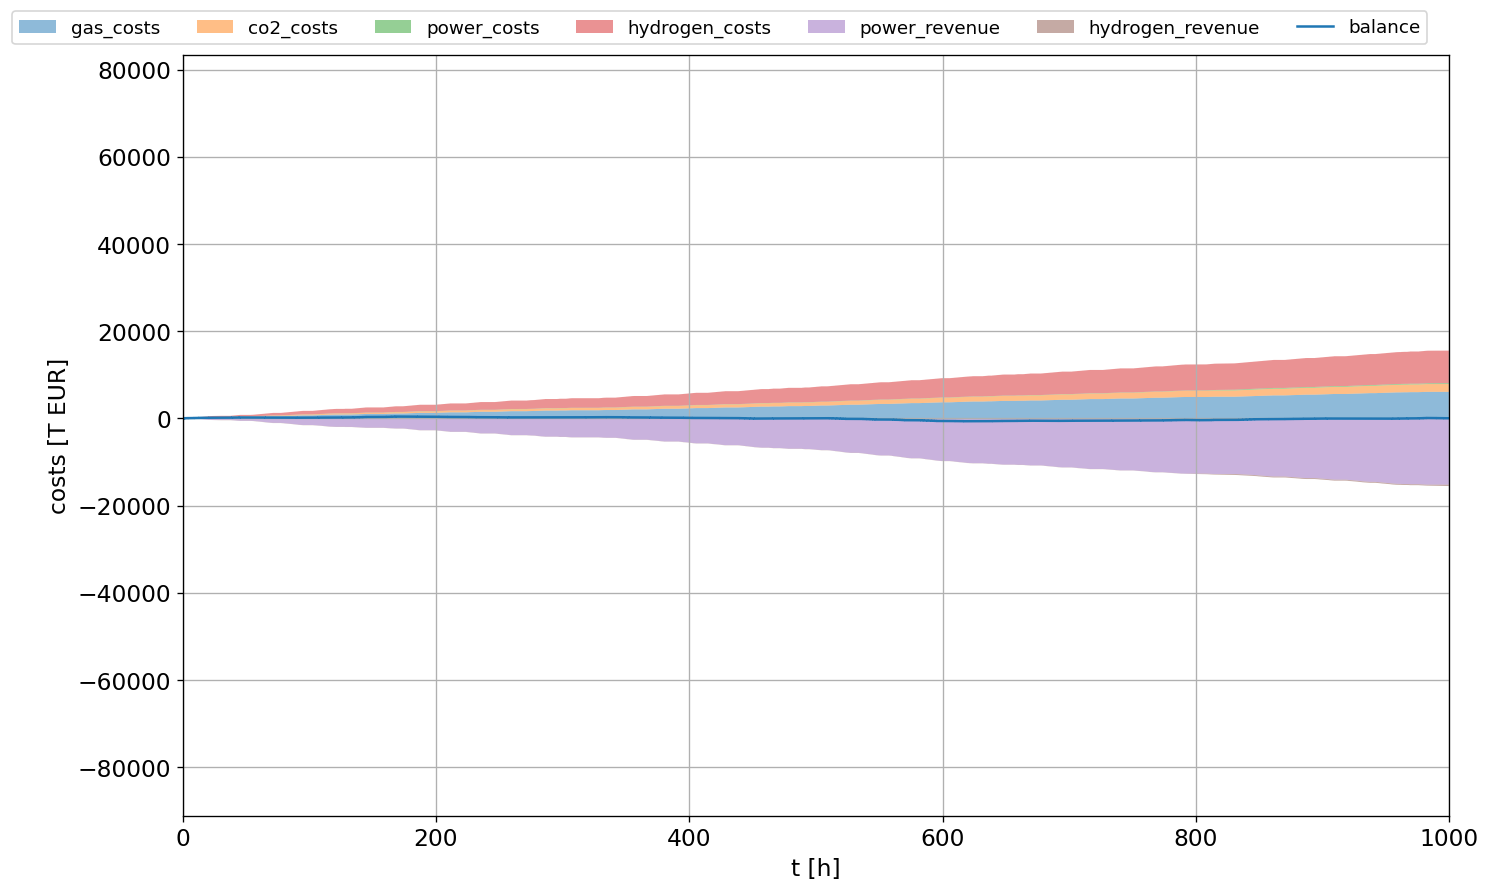

In [77]:
XLIM = (0, 1000)   # Needs to be None or a tuple of min and max xlim

plot_battery_storage(xlim=XLIM)
plot_heat_storage(xlim=XLIM)
plot_energy_balance(xlim=XLIM)
plot_costs(xlim=XLIM)

In [37]:
def calc_costs(assets):
    power_data = assets.asset_data['electrical_grid']['power_balance']
    hydrogen_data = assets.asset_data['hydrogen_grid']['hydrogen_balance']
    ngas_costs = (
        assets.asset_data['ngas_grid']['ngas_balance'] 
        * assets.input_data['gas_price']
        / 1000).sum()
    co2_costs = ((
        assets.asset_data['chp_1']['co2'] * CO2_PRICE 
        + assets.asset_data['chp_2']['co2'] * CO2_PRICE)
        / 1000).sum()
    power_costs = (
        power_data.where(power_data >= 0, 0) 
        * assets.input_data['power_price']
        / 1000).sum()
    power_revenue = (
        power_data.where(power_data <= 0, 0) 
        * assets.input_data['power_price']
        / 1000
        * -1).sum()
    hydrogen_costs = (
        hydrogen_data.where(hydrogen_data >= 0, 0) 
        * H2_PRICE
        / 1000).sum()
    hydrogen_revenue = (
        hydrogen_data.where(hydrogen_data <= 0, 0) 
        * H2_PRICE 
        / 1000
        * -1).sum()
    df = pd.DataFrame({
        'ngas_costs' : ngas_costs,
        'co2_costs' : co2_costs,
        'power_costs' : power_costs,
        'power_revenue' : power_revenue,
        'hydrogen_costs' : hydrogen_costs,
        'hydrogen_revenue' : hydrogen_revenue
    }.items(), columns=['position', 'value'])
    df.set_index('position', inplace=True)

    return df


In [46]:
output_df_s1 = pd.read_csv(OUTPUT_PATH + 'only_ngas_output.csv', index_col=0)
output_df_s2 = pd.read_csv(OUTPUT_PATH + 'ngas_h2_50_50_output.csv', index_col=0)
output_df_s3 = pd.read_csv(OUTPUT_PATH + 'only_h2_output.csv', index_col=0)

In [47]:
assets_s1 = Assets(output_df_s1)
assets_s2 = Assets(output_df_s2)
assets_s3 = Assets(output_df_s3)

df_s1 = pd.DataFrame(assets_s1.postprocess_data)
df_s2 = pd.DataFrame(assets_s2.postprocess_data)
df_s3 = pd.DataFrame(assets_s3.postprocess_data)

cost_df_s1 = calc_costs(assets_s1)
cost_df_s2 = calc_costs(assets_s2)
cost_df_s3 = calc_costs(assets_s3)

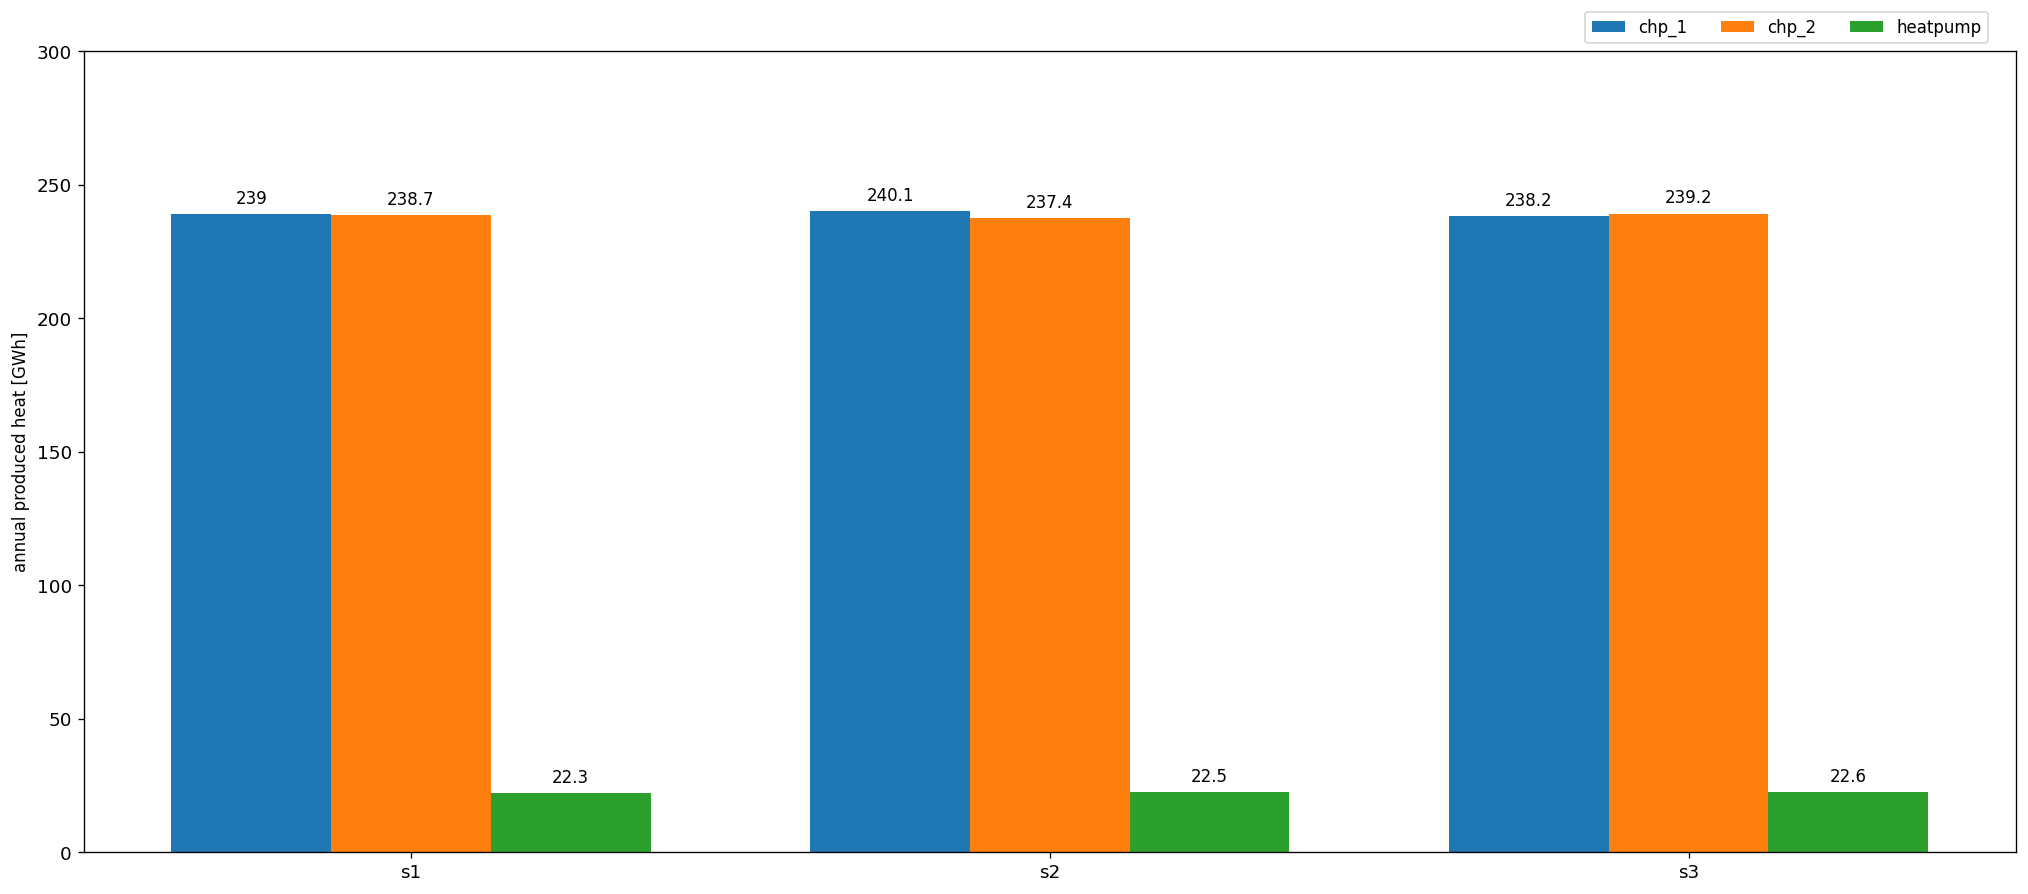

In [48]:
scenarios = ['s1', 's2', 's3']
thermal_assets = {}

for thermal_asset in ['chp_1', 'chp_2', 'heatpump']:
    data_list = []
    for df in [df_s1, df_s2, df_s3]:
        data_list.append(round(df[thermal_asset]['heat'] / 1000, 1))
    thermal_assets[thermal_asset] = data_list

x = np.arange(len(scenarios))
width = 0.25
mulitplier = 0

fig, ax = plt.subplots(figsize=(17, 7.5), dpi=120)

for asset, data in thermal_assets.items():
    offset = width * mulitplier
    bars = ax.bar(x + offset, data, width, label=asset)
    ax.bar_label(bars, padding=4)
    mulitplier += 1
    
ax.set_xticks(x + width, scenarios)
ax.legend(ncol=3, bbox_to_anchor=(0.99, 1.06))
ax.set_ylim(0, 300)
ax.set_ylabel('annual produced heat [GWh]')
fig.tight_layout()


In [49]:
cost_df_s1

,value
position,
ngas_costs,56695.408492
co2_costs,17621.286462
power_costs,1318.363011
power_revenue,80668.113005
hydrogen_costs,0.000000
hydrogen_revenue,2548.242278


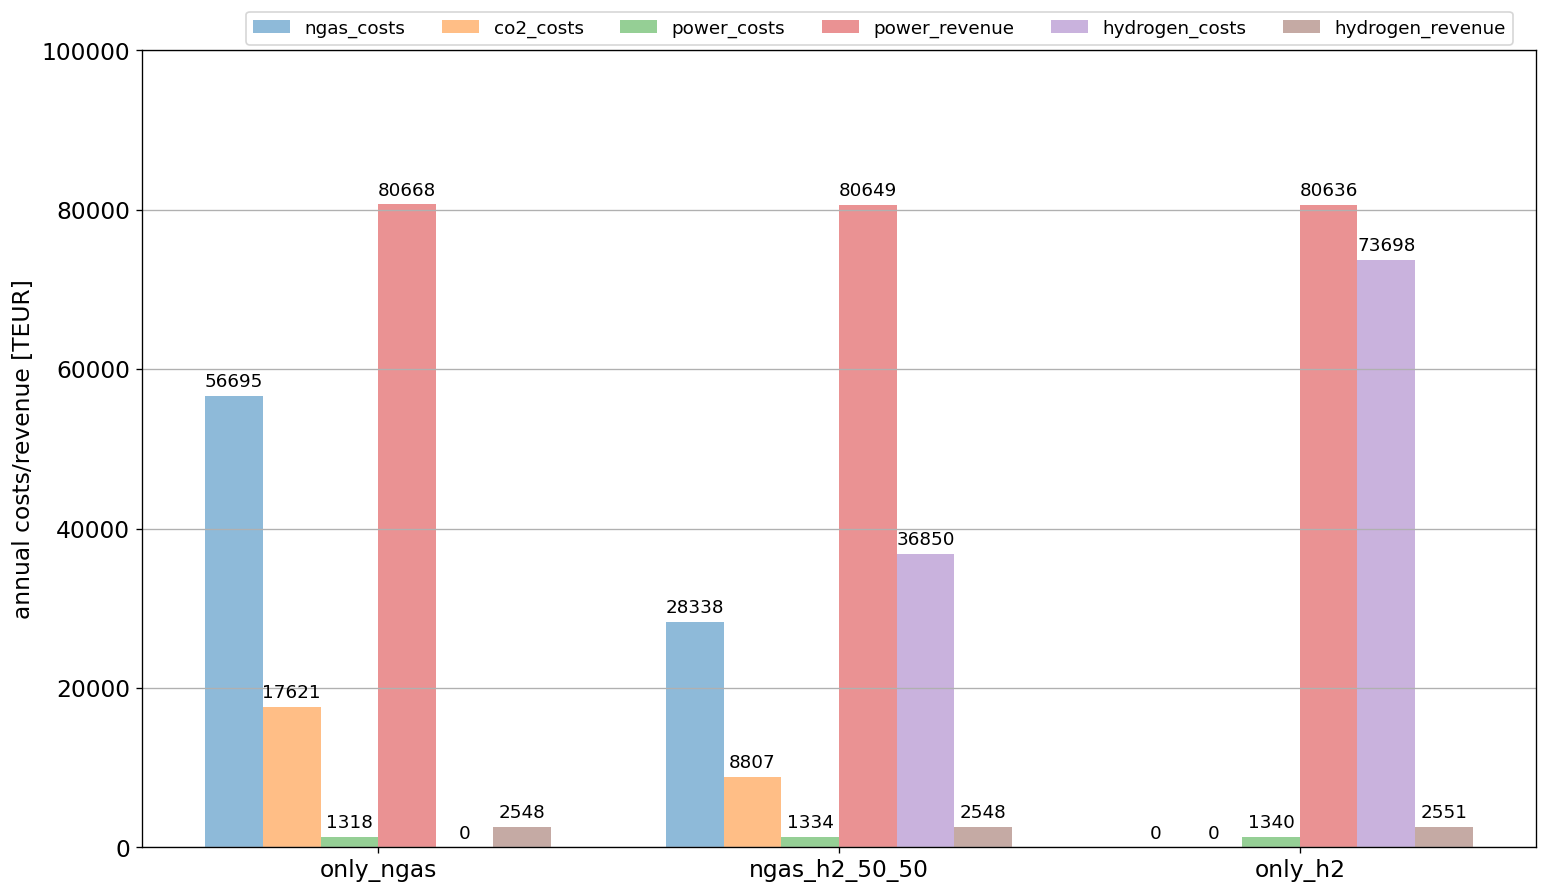

In [61]:
FONTSIZE = 11
LABELSIZE = 14

plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

scenarios = ['only_ngas', 'ngas_h2_50_50', 'only_h2']
cost_data = {}

for cost_position in ['ngas_costs', 'co2_costs', 'power_costs', 'power_revenue', 'hydrogen_costs', 'hydrogen_revenue']:
    data_list = []
    for df in [cost_df_s1, cost_df_s2, cost_df_s3]:
        data_list.append(round(df['value'][cost_position], 0))
    cost_data[cost_position] = data_list

x = np.arange(len(scenarios))
width = 0.125
mulitplier = 0

fig, ax = plt.subplots(figsize=(13, 7.5), dpi=120)

for position, data in cost_data.items():
    offset = width * mulitplier
    bars = ax.bar(x + offset, data, width, label=position, alpha=0.5)
    ax.bar_label(bars, padding=3, fontsize=FONTSIZE)
    mulitplier += 1
    
ax.set_xticks(x + 2.5*width, scenarios)
ax.legend(ncol=6, bbox_to_anchor=(0.99, 1.06), fontsize=FONTSIZE)
ax.set_ylim(0, 100000)
ax.set_ylabel('annual costs/revenue [TEUR]', fontsize=LABELSIZE)
ax.grid(axis = 'y')
fig.tight_layout()

Plot Binary

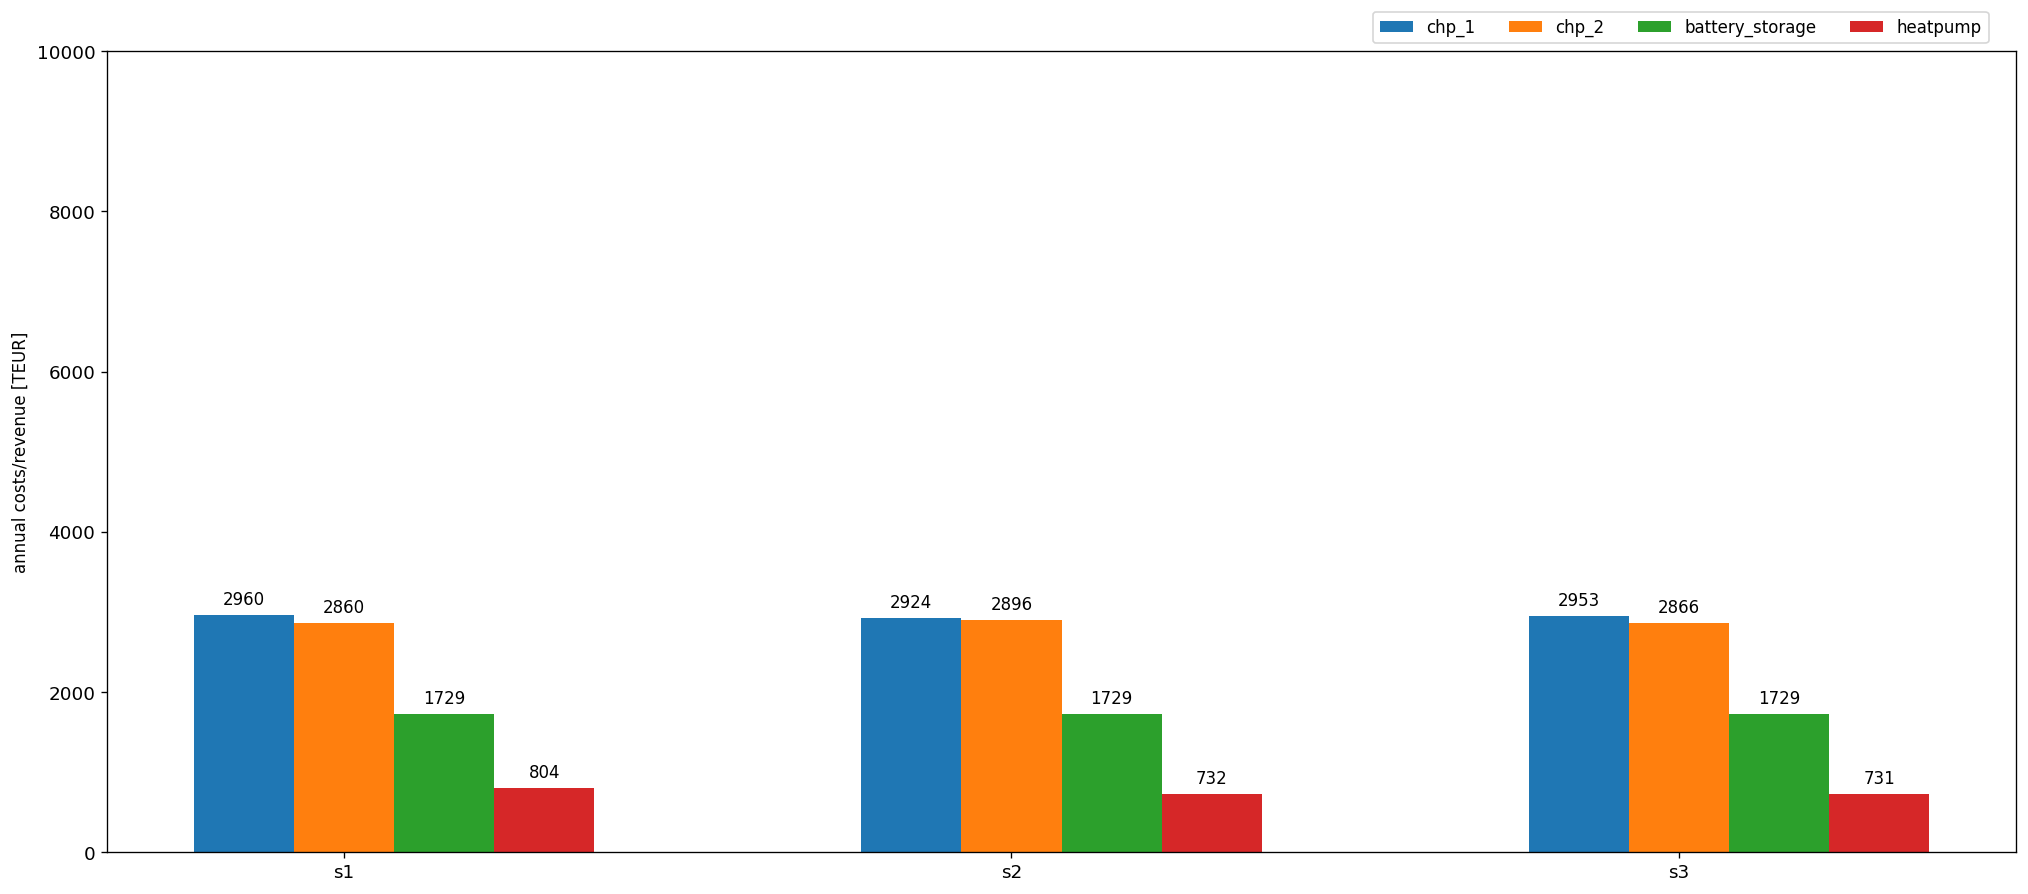

In [43]:
scenarios = ['s1', 's2', 's3']
bin_data = {}

for asset in ['chp_1', 
              'chp_2', 
              'battery_storage', 
              'heatpump']:
    data_list = []
    for df in [df_s1, df_s2, df_s3]:
        if asset == 'battery_storage':
            data_list.append(df[asset]['bin_switch'])
        else:
            data_list.append(df[asset]['bin'])
    bin_data[asset] = data_list

x = np.arange(len(scenarios))
width = 0.15
mulitplier = 0

fig, ax = plt.subplots(figsize=(17, 7.5), dpi=120)

for position, data in bin_data.items():
    offset = width * mulitplier
    bars = ax.bar(x + offset, data, width, label=position)
    ax.bar_label(bars, padding=4)
    mulitplier += 1
    
ax.set_xticks(x + width, scenarios)
ax.legend(ncol=6, bbox_to_anchor=(0.99, 1.06))
ax.set_ylim(0, 10000)
ax.set_ylabel('annual costs/revenue [TEUR]')
fig.tight_layout()

Jahresdauerlinie

In [44]:
def plot_annual_load_curve(asset_data, asset_names):
    fig, ax = plt.subplots(figsize=(17, 7.5), dpi=120)

    for asset_name in asset_names:
        if asset_name == 'battery_storage':
            ax.plot(asset_data[asset_name]['power_content'].sort_values(ascending=False, ignore_index=True))
        else:
            ax.plot(asset_data[asset_name]['power'].sort_values(ascending=False, ignore_index=True))

# scenarios = ['s1', 's2', 's3']
# asset_names = ['chp_1', 'chp_2', 'electrolyzer_1']

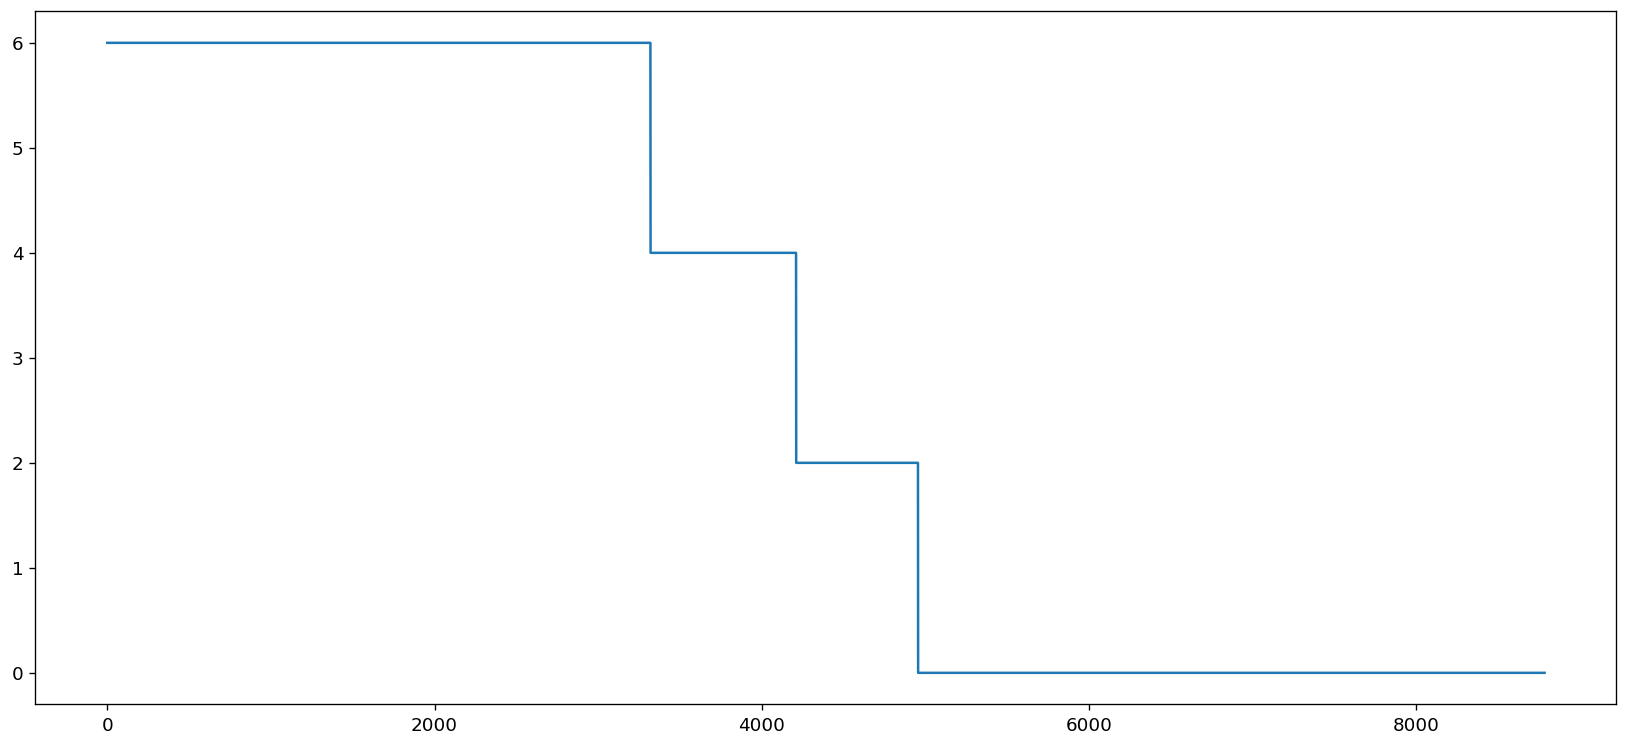

In [45]:
plot_annual_load_curve(assets_s1.asset_data, ['battery_storage'])
